# Clustering

Esta técinica de modelado buscará segmentar las resevras según sus comportamientos de consumo

## Contexto

Despues de aplicar técias de Data Governace en etapas anteriores del proyecto, nos encontramos con una tabla de reservaciones estructurada de la siguiente manera:

In [1]:
import pandas as pd

rsv = pd.read_csv('/Users/manuelrodriguez/Documents/Proyectos/ML_Models/Data/rsv_limpio.csv')
rsv.info

<bound method DataFrame.info of       ID_Reserva   Fecha_hoy                      h_res_fec h_res_fec_ok  \
0             11  2019-11-01  1970-01-01 00:00:00.020191101   2019-11-01   
1             15  2019-04-27  1970-01-01 00:00:00.020190427   2019-04-27   
2             32  2019-11-14  1970-01-01 00:00:00.020191114   2019-11-14   
3             57  2019-04-29  1970-01-01 00:00:00.020190429   2019-04-29   
4             76  2019-12-18  1970-01-01 00:00:00.020191218   2019-12-18   
...          ...         ...                            ...          ...   
5570      101971  2020-04-23  1970-01-01 00:00:00.020200423   2020-04-23   
5571      101972  2020-04-23  1970-01-01 00:00:00.020200423   2020-04-23   
5572      102052  2020-04-25  1970-01-01 00:00:00.020200425   2020-04-25   
5573      102054  2020-04-17  1970-01-01 00:00:00.020200417   2020-04-17   
5574      102156  2020-04-07  1970-01-01 00:00:00.020200407   2020-04-07   

     h_res_fec_okt  h_num_per  h_num_adu  h_num_men  h_

A pesar de esto, pasaremos el dataframe a través de un nuevo proceso de selección y limpieza de variables enfocado a clustering

## Preprocesamiento

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

cols_clustering = [
    'h_num_per', 'h_num_adu', 'h_num_men', 'h_tfa_total', 'moneda_cve'
]

rsv_clustering = rsv[cols_clustering].copy()

rsv_clustering.dropna(inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rsv_clustering)

## GridSearch
Utilizaremos GridSearch para encontrara el número óptimo de clusters

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

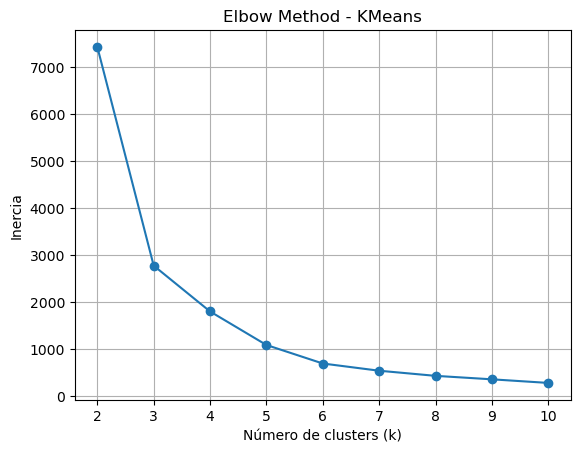

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method - KMeans")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

Podemos ver que el número ideal de K se encuntra en 6

## Aplicación de modelos de Clustering
Aplicaremos diferentes métodos de Clustering, para después comparar sus desempeños y elegir el que mejor se adecúa a nuestro caso

In [5]:
kmeans = KMeans(n_clusters=6, random_state=42)
rsv_clustering['kmeans_cluster'] = kmeans.fit_predict(X_scaled) +1

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## DBSCAN

In [6]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=10)
rsv_clustering['dbscan_cluster'] = db.fit_predict(X_scaled)


## GMM 

In [7]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6, random_state=42)
rsv_clustering['gmm_cluster'] = gmm.fit_predict(X_scaled)


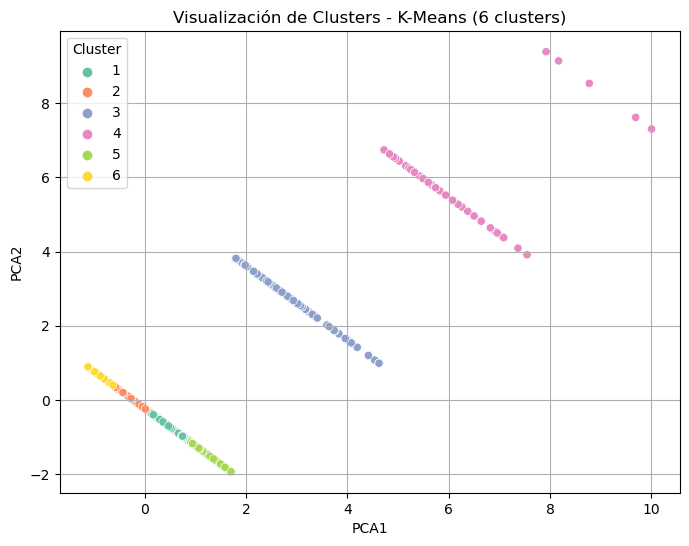

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
df_pca['kmeans_cluster'] = kmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='kmeans_cluster', palette='Set2')
plt.title("Visualización de Clusters - K-Means (6 clusters)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

## Comparación de métricas

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels, name):
    print(f"--- {name} ---")
    print("Silhouette Score:", silhouette_score(X, labels))
    print("Calinski-Harabasz Index:", calinski_harabasz_score(X, labels))
    print("Davies-Bouldin Index:", davies_bouldin_score(X, labels))
    print()

kmeans_labels = kmeans.fit_predict(X_scaled) + 1
evaluate_clustering(X_scaled, kmeans_labels, "K-Means")

dbscan_labels = db.fit_predict(X_scaled)
evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")

gmm_labels = gmm.fit_predict(X_scaled) + 1
evaluate_clustering(X_scaled, gmm_labels, "GMM")


/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


--- K-Means ---
Silhouette Score: 0.588609363606369
Calinski-Harabasz Index: 16690.433486757818
Davies-Bouldin Index: 0.4901251538586997

--- DBSCAN ---
Silhouette Score: 0.7448097092873835
Calinski-Harabasz Index: 1859.7076446235883
Davies-Bouldin Index: 0.4464331202604392

--- GMM ---
Silhouette Score: 0.5105410943424581
Calinski-Harabasz Index: 12388.003039786166
Davies-Bouldin Index: 0.4723641008963341

